# Afternoon Activity - Day 6

#### This notebook was developed by [Zeljko Ivezic](http://faculty.washington.edu/ivezic/) for the 2021 data science class at the University of Sao Paulo and it is available from [github](https://github.com/ivezic/SaoPaulo2021/blob/main/notebooks/Activity6.ipynb).



## Problem 1: robust statistics for Cauchy distribution

Using astroML figure 3.12 as a template, see

http://www.astroml.org/book_figures/chapter3/fig_cauchy_median_mean.html

add another panel, similar to the top panel, that will plot and compare 
results for standard deviation and $\sigma_G$. 

## Problem 2: optimal bin width for constant-bin-width histograms:

### Problem 2a 

Generate a sample of 10,000 data values drawn from N($\mu$=1.0, $\sigma$=0.2) and
draw a pretty histogram, with the bin size determined using the Freedman-Diaconis
rule. Show (Poissonian) uncertainty for each histogram value, and overplot the
true distribution. 

### Problem 2b

Do the same for a Cauchy distribution with the same $\mu$ and $\gamma=0.2$. 

### Problem 2c
Repeat the problem 2, but now add to the Gaussian sample (concatenate arrays) 
another sample of 10,000 data values drawn from a Cauchy distribution with
$\mu=2.0$ and $\gamma=0.5$. Do it twice: once with the bin size determined 
using the Freedman-Diaconis rule and once using the Scott's rule. Discuss the difference.  


## Problem 3: posterior probability for binomial distribution

The posterior pdf for $b$, the tail probability when flipping a coin, 
with a flat prior in the range 0-1, is 
$$ p(b \,|\, k, N ) = C \, b^k \, (1-b)^{N-k}, $$
where the normalization constant $C$ can be determined from the condition $\int_0^1 p(b\,|\,k,N)\, db = 1$.

Get a coin, flip it 8 times and record the results.

a) plot $p(b \,|\, k, N )$ after each flip. Every time show the previous (prior) $p(b)$
and the posterior $p(b)$. 

b) After all 8 flips, what is the probability that your coin strongly prefers
heads over tails: what is the probability $p(b<0.25\,|\, k, N )$)? 


## Extra Activity: Bayesian Blocks Algorithm

### Some useful definitions and functions

In [16]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize
from scipy import stats
from scipy.stats import cauchy, norm

import seaborn as sns; sns.set() # set default plot styles
from astroML.plotting import setup_text_plots
from astroML.stats import sigmaG
from astroML.plotting import hist as fancyhist
from astroML.plotting import hist

from scipy import stats
from scipy.stats import norm

setup_text_plots(fontsize=14, usetex=True)

## Problem 1

In [17]:
def robust_mean_mixture(x):
    """Compute the mean via a mixture of two Gaussians

    One Gaussian accounts for outliers, and one Gaussian accounts  for
    the true distribution.  This cannot be computed analytically, so
    it uses scipy's function optimization
    """
    if len(x) == 1:
        return x

    x = x.ravel()

    mu_bg = np.mean(x)
    sig_bg = 3 * np.std(x)

    likelihood = lambda v: -np.sum(np.log(norm.pdf(x, v[0], v[1])
                                          + norm.pdf(x, mu_bg, sig_bg)))

    v0 = np.array([0, 30])

    v_best = optimize.fmin(likelihood, v0, disp=False)

    return v_best[0]


def robust_mean_iterated(x, sigma_cut=3):
    """Compute the robust mean iteratively

    After computing the mean, points further than 3 sigma from the mean
    are removed and the result is repeated until convergence.
    """
    flag = np.ones(x.shape, dtype=bool)
    n_to_keep = x.size

    while True:
        xf = x[flag]
        mu = xf.mean()
        sig = xf.std()
        if len(xf) == 1:
            break

        x_sig = abs((x - mu) / sig)

        too_far = (x_sig > sigma_cut)
        flag[too_far] = False
        n_flag = flag.sum()

        if n_flag == n_to_keep:
            break
        else:
            n_to_keep = n_flag

    return mu
 

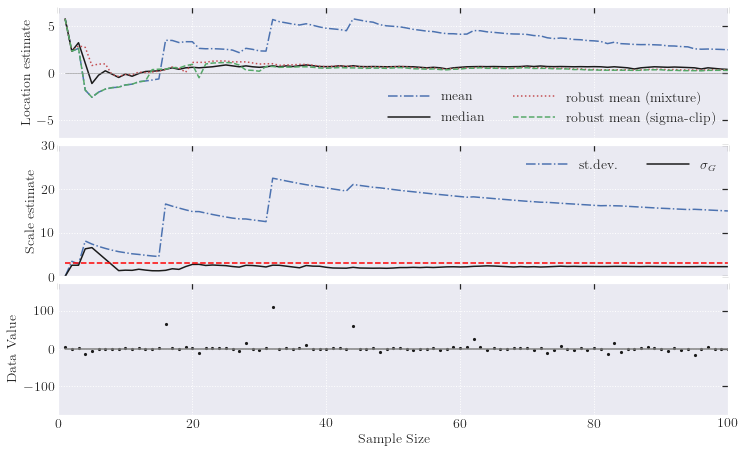

In [18]:
#------------------------------------------------------------
# Create the distribution and compute means and medians
np.random.seed(6)
mu = 0
gamma = 2

xi = cauchy(mu, gamma).rvs(100)
Nrange = np.arange(1, len(xi) + 1)

mean = [np.mean(xi[:N]) for N in Nrange]
median = [np.median(xi[:N]) for N in Nrange]
mean_mixture = [robust_mean_mixture(xi[:N]) for N in Nrange]
mean_iter = [robust_mean_iterated(xi[:N]) for N in Nrange]

# additions
stdev = [np.std(xi[:N]) for N in Nrange]
sigG = [sigmaG(xi[:N]) for N in Nrange]

# Plot the results as a function of number of points
fig = plt.figure(figsize=(12, 7.5))
fig.subplots_adjust(hspace=0.05)

# first plot the mean and median
ax = fig.add_subplot(311)
ax.plot(Nrange, mean, '-.b', label='mean')
ax.plot(Nrange, median, '-k', label='median')
ax.plot(Nrange, mean_mixture, ':r', label='robust mean (mixture)')
ax.plot(Nrange, mean_iter, '--g', label='robust mean (sigma-clip)')
ax.plot(Nrange, 0 * Nrange, '-', c='gray', lw=0.5)

ax.set_xlim(0, 100)
ax.set_ylim(-7, 7)
ax.legend(loc=4, ncol=2, frameon=False)
ax.set_ylabel('Location estimate')
ax.xaxis.set_major_formatter(plt.NullFormatter())

# and here plot the sigma and sigmaG
ax = fig.add_subplot(312)
ax.plot(Nrange, stdev, '-.b', label='st.dev.')
ax.plot(Nrange, sigG, '-k', label='$\sigma_G$')
## sigmaG for Cauchy distribution
ax.plot(Nrange, (1.483*gamma+0 * Nrange), '--', c='red')
ax.set_xlim(0, 100)
ax.set_ylim(0, 30)
ax.legend(loc='upper right', ncol=2, frameon=False)
ax.set_ylabel('Scale estimate')
ax.xaxis.set_major_formatter(plt.NullFormatter())

# now plot the data values
ax = fig.add_subplot(313)
ax.scatter(Nrange, xi, lw=0, s=10, c='k')
ax.plot(Nrange, 0 * Nrange, '-', c='gray')
ax.set_xlim(0, 100)
ax.set_ylim(-175, 175)
ax.set_xlabel('Sample Size')
ax.set_ylabel('Data Value')
plt.show()

## Problem 2a
Generate a sample of 10,000 data values drawn from N(1,0.2) and draw a pretty histogram, with the bin size determined using the Freedman-Diaconis rule. Show (Poissonian) uncertainty for each histogram value, and overplot the true distribution.


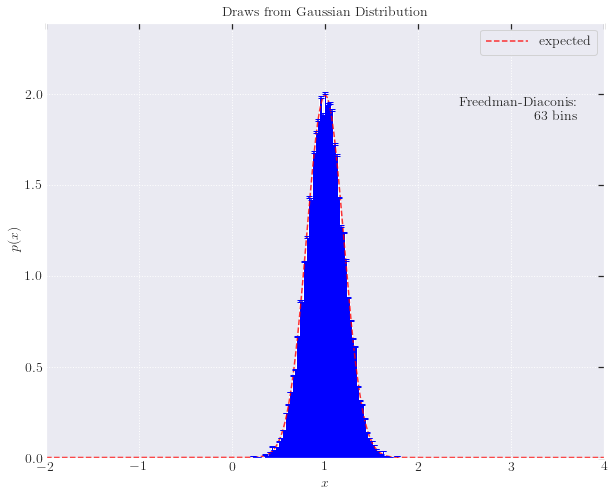

In [19]:
### this code taken from (and modified)
### http://www.astroml.org/book_figures/chapter5/fig_hist_binsize.html
def plot_fancy_histogram(style, data, name, ax=None):
    if ax is not None:
        ax = plt.axes(ax)
    counts, bins, patches = fancyhist(data, bins=style, ax=ax,
                                 color='blue', histtype='stepfilled', density=True)
    # add error bars 
    bincenters = 0.5 * (bins[1:] + bins[:-1])  
    binwidth = bins[1] - bins[0]
    countsErr = np.sqrt(counts) / binwidth / np.size(xData)
    plt.errorbar(bincenters, counts, countsErr, fmt = 'none', ecolor = 'blue')

    ax.text(0.95, 0.83, '%s:\n%i bins' % (name, len(counts)),
            transform=ax.transAxes,
            ha='right', va='top')
    return


### this code taken from the lecture (and modified)
### https://github.com/uw-astr-324-s17/astr-324-s17/blob/master/notebooks/Week-2-Thu.ipynb

# 1) draw k=10,000 numbers from N(mu=1.0, sigma=0.2) 
np.random.seed(42)
k = 10000
mu = 1.0
sigma = 0.2
xData = norm(mu, sigma).rvs(k) # here we draw k numbers from N(mu, sigma)

## now plot the histogram of values
fig, ax = plt.subplots(figsize=(10, 8))

# expected gaussian distribution
xGrid = np.linspace(-2, 4, 1000)
gaussL = norm(mu, sigma).pdf(xGrid)  # this is a function of x: gauss(x)
plt.plot(xGrid, gaussL, ls='--', c='red', label='expected', alpha = 0.8)

# histogram the data
plot_fancy_histogram('freedman', xData, 'Freedman-Diaconis', ax=ax)

plt.xlim(-2.0, 4.0)
yMax = 1.2/ np.sqrt(2*3.14) / sigma 
plt.ylim(0, yMax)
plt.xlabel('$x$')
plt.ylabel(r'$p(x)$')
plt.title('Draws from Gaussian Distribution')
plt.legend()
plt.show()

## Problem 2b
Do the same for a Cauchy distribution with the same $\mu$ and $\gamma=0.2$. 

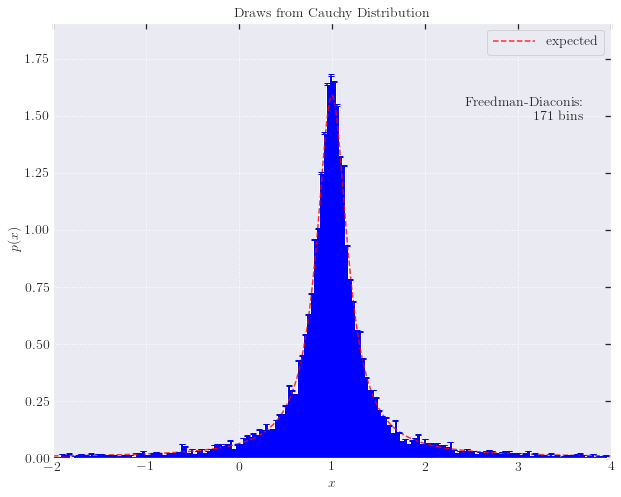

In [20]:
# 1) draw k=10,000 numbers from Cauchy(mu=1.0, sigma=0.2) 
np.random.seed(42)
k = 10000
mu = 1.0
gamma = 0.2
xData = cauchy(mu, gamma).rvs(k)  
xData = xData[(xData > -2) & (xData < 4)]
## now plot the histogram of values
fig, ax = plt.subplots(figsize=(10, 8))
# expected gaussian distribution
xGrid = np.linspace(-2, 4, 1000)
cauchyL = cauchy(mu, gamma).pdf(xGrid)  # this is a function of x 
plt.plot(xGrid, cauchyL, ls='--', c='red', label='expected', alpha = 0.8)

# histogram the data
# the following line is from the lecture, with the bin size set by hand
# ax.hist(xData, bins=np.linspace(0.0, 2.0, 100), histtype='stepfilled', alpha=0.5, normed=True)
# and this function calls the fancy code from astroML:
plot_fancy_histogram('freedman', xData, 'Freedman-Diaconis', ax=ax)

plt.xlim(-2.0, 4.0)
yMax = 1.2/ 3.14 / gamma
plt.ylim(0, yMax)
plt.xlabel('$x$')
plt.ylabel(r'$p(x)$')
plt.title('Draws from Cauchy Distribution')
plt.legend()
plt.show()

## Problem 2c
Repeat the problem 2, but now add to the Gaussian sample (concatenate arrays) 
another sample of 10,000 data values drawn from a Cauchy distribution with
$\mu=2.0$ and $\gamma=0.5$. Do it twice: once with the bin size determined 
using the Freedman-Diaconis rule and once using the Scott's rule. Comment.  

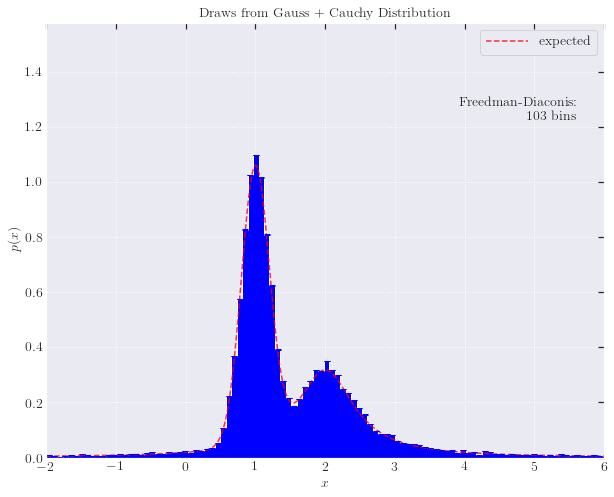

In [21]:
# draw k=10,000 numbers from N(mu=1.0, sigma=0.2) 
# and another k=10,000 numbers from Cauchy(mu=2.0, sigma=0.5) 
np.random.seed(42)
k1 = 10000
mu = 1.0
sigma = 0.2
xDataG = norm(mu, sigma).rvs(k1)  
k2 = 10000
mu2 = 2.0 
gamma = 0.5
xDataC = cauchy(mu2, gamma).rvs(k2)  
xDataC = xDataC[(xDataC > -2) & (xDataC < 6)]
k = k1 + k2
xData = np.concatenate((xDataG, xDataC), axis=0)

## now plot the histogram of values
fig, ax = plt.subplots(figsize=(10, 8))

# expected distribution
xGrid = np.linspace(-2, 6, 1000)
gaussL = norm(mu, sigma).pdf(xGrid)   
cauchyL = cauchy(mu2, gamma).pdf(xGrid)  
expectedD = (k1*gaussL + k2*cauchyL)/k
plt.plot(xGrid, expectedD, ls='--', c='red', label='expected', alpha = 0.8)

# histogram the data
# the following line is from the lecture, with the bin size set by hand
# ax.hist(xData, bins=np.linspace(0.0, 2.0, 100), histtype='stepfilled', alpha=0.5, normed=True)
# and this function calls the fancy code from astroML:
plot_fancy_histogram('freedman', xData, 'Freedman-Diaconis', ax=ax)

plt.xlim(-2.0, 6.0)
yMax = 1.2/k * (k1/ np.sqrt(2*3.14) / sigma + k2/ 3.14 / gamma)
plt.ylim(0, yMax)
plt.xlabel('$x$')
plt.ylabel(r'$p(x)$')
plt.title('Draws from Gauss + Cauchy Distribution')
plt.legend()
plt.show()

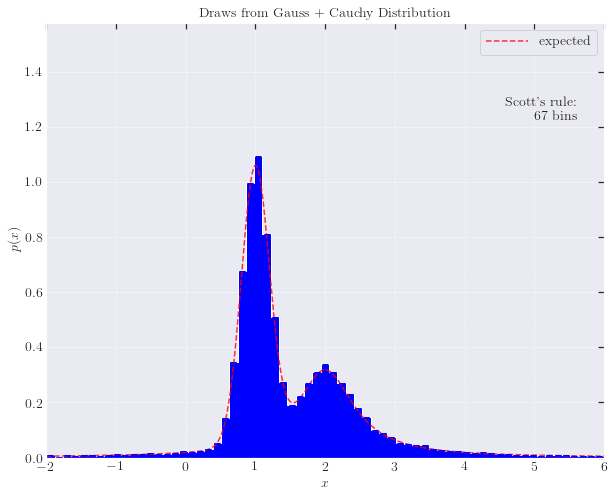

In [22]:
## now plot the histogram of values
fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(xGrid, expectedD, ls='--', c='red', label='expected', alpha = 0.8)

# histogram the data
# the following line is from the lecture, with the bin size set by hand
# ax.hist(xData, bins=np.linspace(0.0, 2.0, 100), histtype='stepfilled', alpha=0.5, normed=True)
# and this function calls the fancy code from astroML:
plot_fancy_histogram('scott', xData, 'Scott\'s rule', ax=ax)

plt.xlim(-2.0, 6.0)
yMax = 1.2/k * (k1/ np.sqrt(2*3.14) / sigma + k2/ 3.14 / gamma)
plt.ylim(0, yMax)
plt.xlabel('$x$')
plt.ylabel(r'$p(x)$')
plt.title('Draws from Gauss + Cauchy Distribution')
plt.legend()
plt.show()

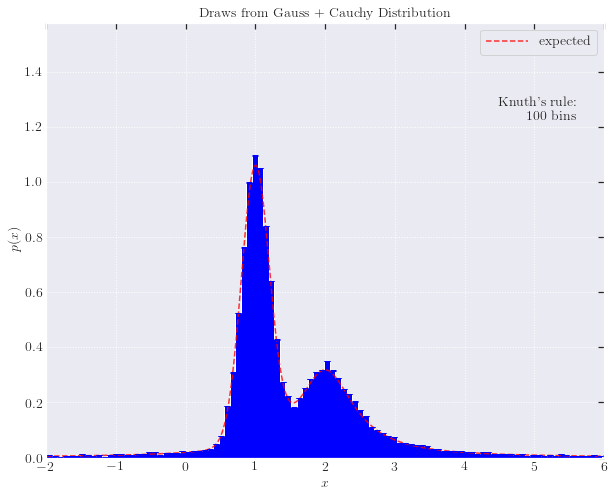

In [23]:
## now plot the histogram of values
fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(xGrid, expectedD, ls='--', c='red', label='expected', alpha = 0.8)

# histogram the data
# the following line is from the lecture, with the bin size set by hand
# ax.hist(xData, bins=np.linspace(0.0, 2.0, 100), histtype='stepfilled', alpha=0.5, normed=True)
# and this function calls the fancy code from astroML:
plot_fancy_histogram('knuth', xData, 'Knuth\'s rule', ax=ax)

plt.xlim(-2.0, 6.0)
yMax = 1.2/k * (k1/ np.sqrt(2*3.14) / sigma + k2/ 3.14 / gamma)
plt.ylim(0, yMax)
plt.xlabel('$x$')
plt.ylabel(r'$p(x)$')
plt.title('Draws from Gauss + Cauchy Distribution')
plt.legend()
plt.show()

## Problem 3: binomial distribution (the coin flip)

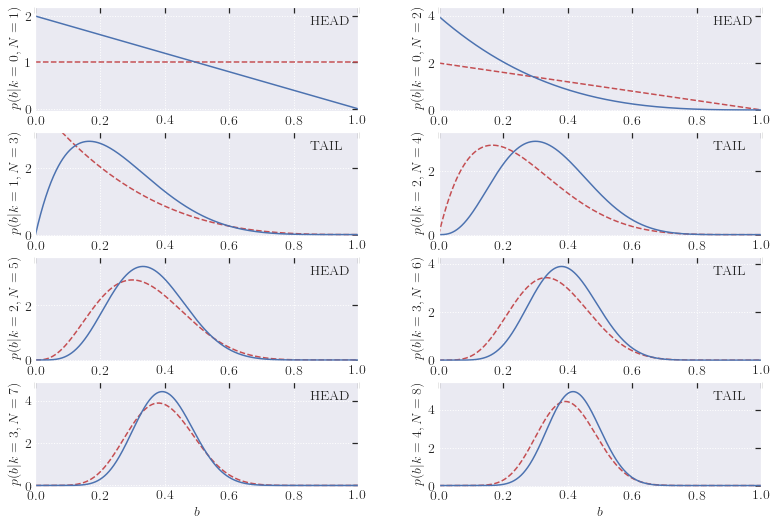

p(b<0.25):  0.011894078069101604


In [26]:
from scipy.stats import norm
np.random.seed(42)
# results for my coin (0:head, 1: tail)
flipData = [0, 0, 1, 1, 0, 1, 0, 1]
# plotting setup 
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.25, bottom=0.18)
 
# b grid for computing p(b) 
b = np.linspace(0,1,1000)
db = b[1]-b[0]
# prior 
p_b = 1.0 + 0*b   # flat prior
# p_b = norm(0.5, 0.1).pdf(b)   Gaussian prior

# loop over data
for i in range(1,9):
    ax = fig.add_subplot('52' + str(i))
    # show p_b before this data point is added
    ax.plot(b, p_b, '--r')
    # now get new p_b
    N = i 
    k = flipData[0:i].count(1)
    p_b = p_b * (b ** k * (1 - b) ** (N - k))
    p_b /= p_b.sum()
    p_b /= db
    # p_b after this data point is added
    label=' z'
    ax.plot(b, p_b, '-b', label=label)
    ax.set_xlabel('$b$')
    s = '$p(b|k=%i' % k
    s = s + ', N=%i)$' % N
    if (flipData[i-1] == 0): 
        ax.text(0.85, np.max(p_b)*0.9,'HEAD')
    else:
        ax.text(0.85, np.max(p_b)*0.9,'TAIL')
    ax.set_ylabel(s)
    ax.set_ylim(-0.05, np.max(p_b)*1.1)
    
plt.show()

cuml_p_b = p_b.cumsum()
cuml_p_b /= cuml_p_b[-1]
print('p(b<0.25): ', np.interp(0.25, b, cuml_p_b)) 


## Bayesian Blocks algorithm

Though Knuth’s Bayesian method for choosing histogram bin width is an improvement over 
the Scott’s rule and the Freedman–Diaconis rule, it still has a distinct weakness: 
it assumes a **uniform** width for the optimal histogram bins.  

This limitation can be lifted by maximizing a well-designed likelihood function over 
bins of varying width. This approach has been dubbed Bayesian blocks. The method was 
first developed in the field of time-domain analysis, but is readily applicable to 
histogram data as well. 


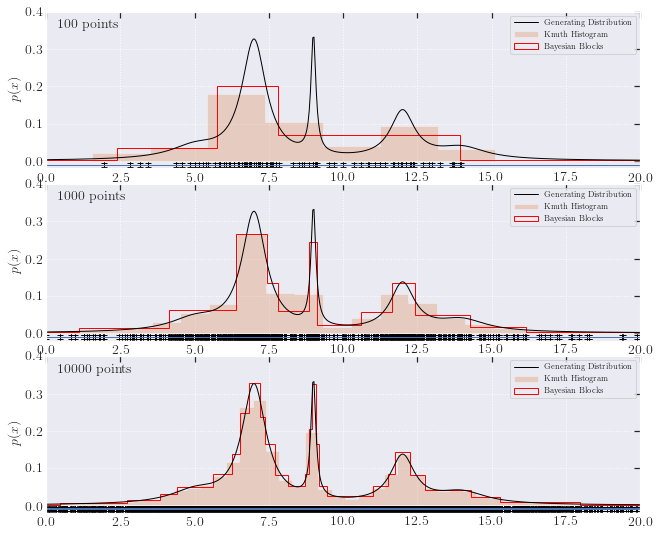

In [25]:
# Generate sample: a mix of several Cauchy distributions
np.random.seed(0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N))
                    for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
N_values = (100, 1000, 10000)
subplots = (311, 312, 313)

for N, subplot in zip(N_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]
    t = np.linspace(-10, 30, 1000)

    # plot the results
    ax.errorbar(xN, -0.01 + 0*xN, xerr=0.0, yerr=0.005, ecolor='black', lw=1)
    ax.plot(t, true_pdf(t), '-', color='black', lw=1,
            label="Generating Distribution")
    hist(xN, bins='knuth', ax=ax, density=True,
         histtype='stepfilled', alpha=0.3,
         label='Knuth Histogram')
    hist(xN, bins='blocks', ax=ax, density=True,
         histtype='step', color='red', alpha=0.99,
         label="Bayesian Blocks")
  
    # label the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.set_ylabel('$p(x)$')
    ax.legend(loc='upper right', prop=dict(size=8))

    if subplot == 212:
        ax.set_xlabel('$x$')

    ax.set_xlim(0, 20)
    ax.set_ylim(-0.02, 0.4001)

plt.show()


#### Note that for the largest sample (N=10,000 points) all methods produces similar results.

#### However, for the smallest sample, differences between the methods are huge! 

#### The Bayesian Blocks method gives the simplest step-function fit supported by data.

### For the remainder of allocated time: 

#### play with the generating function mu_gamma_f and with sample size N and investigate how the results change!